In [1]:
using MatterPower
using Roots
using Plots
using LaTeXStrings
using LinearAlgebra
using Statistics
gr()  # Set GR as the backend

Plots.GRBackend()

In [91]:
module DarkEnergyModule
    using DifferentialEquations
    using PyCall
    using Plots
    using LaTeXStrings
    using QuadGK

    # Import the Python camb module and dark energy submodule
    cb = pyimport("camb")
    DarkEnergyPPF = pyimport("camb.dark_energy").DarkEnergyPPF

    # Define a struct to encapsulate dark energy parameters
    struct DarkEnergyModel
        Ωm::Float64  # Total matter density parameter
        ΩΛ::Float64  # Dark energy density parameter
        w0::Float64  # EoS parameter
        wa::Float64  # Evolution of EoS
        h::Float64   # Hubble constant in units of 100 km/s/Mpc
        pars1::PyObject  # CAMB parameters
        results1::PyObject  # CAMB results
    end

    # Constructor with CAMB setup
    function DarkEnergyModel(Ωm::Float64, ΩΛ::Float64, w0::Float64, wa::Float64, h::Float64)
        # Calculate baryon and cold dark matter densities
        ombh2 = 0.045 * h^2  # Assuming baryon fraction is 0.045
        omch2 = (Ωm - 0.045) * h^2  # Cold dark matter density
        
        # Initialize CAMB parameters
        pars1 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        pars2 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        
        # Configure matter power and non-linear settings
        pars1["set_matter_power"](redshifts=[0.0], kmax=10.0)
        pars1["NonLinear"] = cb.model["NonLinear_none"] #for linear choose _none else _both
        results1 = cb.get_results(pars1)
        
        return DarkEnergyModel(Ωm, ΩΛ, w0, wa, h, pars1, results1)
    end

    # Dynamical dark energy equation of state
    function DE_EoS(self::DarkEnergyModel, redshift::Float64)
        w0, wa = self.w0, self.wa
        return (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
    end


    # Define methods for the DarkEnergyModel struct
    function growth(self::DarkEnergyModel, a1::Real=1e-2)
        Ωm, ΩΛ, w0, wa = self.Ωm, self.ΩΛ, self.w0, self.wa
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a1 - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E1 = √(Ωm / a1^3 + Ωk / a1^2 + ΩΛ * DEoS)
        u0 = [a1; -a1^2 * E1]
        tspan = (a1, 1.0)
        prob = ODEProblem((du, u, p, a) -> growth_set!(du, u, p, a, w0, wa), u0, tspan, [Ωm, ΩΛ])
        return solve(prob, Tsit5())
    end

    function growth_set!(du, u, p, a, w0, wa)
        δ, θ = u
        Ωm, ΩΛ = p
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E = √(Ωm / a^3 + Ωk / a^2 + ΩΛ * DEoS)  # E(a) = H(a)/H0
        q2ϕ = -(3 / 2) * Ωm * δ / a  # Poisson equation
        du[1] = -θ / a^2 / E  # Continuity equation
        du[2] = -θ / a + q2ϕ / a^2 / E  # Euler equation
    end

    # Redshift-dependent growth factor
    function dz(self::DarkEnergyModel, redshift::Float64)
        sol = growth(self)
        a = 1 / (1 + redshift)
        return sol(a)[1]
    end

# Growth rate calculation
    function growth_rate(self::DarkEnergyModel, redshift::Float64)
        step = 0.01  # Step size for numerical stability
        dzda = (dz(self, redshift + step) - dz(self, redshift - step)) / (2 * step)
        g = - (1 + redshift) * dzda / dz(self, redshift)
        return g
    end

    # Normalized Hubble rate
    function normalized_hubble_rate(self::DarkEnergyModel, redshift::Float64)
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        Ωk = 1 - Ωm - ΩΛ
        DEoS = DE_EoS(self, redshift)
        return √(Ωm / (1 + redshift)^(-3) + Ωk / (1 + redshift)^(-2) + ΩΛ * DEoS)
    end

    function comoving_distance(self::DarkEnergyModel, redshift::Union{Float64, AbstractArray{Float64}})
        if isa(redshift, Float64)
            # Single redshift
            integrand(z) = 1 / normalized_hubble_rate(self, z)
            result, error = quadgk(integrand, 0, redshift)
            return result * 2997.98 / self.h
        else
            # Array of redshifts: Apply to each redshift
            return [comoving_distance(self, z) for z in redshift]
        end
    end

    # Angular Diameter Comoving distance in MPc
    function comoving_angular_distance(self::DarkEnergyModel, redshift::Float64)
        return comoving_distance(self, redshift)/(1+redshift)
    end

    # Linear power spectrum from CAMB
    function get_power_spectrum(self::DarkEnergyModel, kh::Vector{Float64}, redshift::Float64)
        # Extract matter power spectrum from CAMB
        _, _, pk_lcdm = self.results1["get_matter_power_spectrum"](minkh=minimum(kh), maxkh=maximum(kh), npoints=length(kh))
        # Convert Python arrays to Julia arrays
        pk_lcdm = collect(pk_lcdm)
         # Normalize the power spectrum using dz
        normalized_pk = pk_lcdm * (dz(self, Float64(redshift))^2 / dz(self, 0.0)^2)
    
        return normalized_pk
    end

    export dz, comoving_distance, comoving_angular_distance, DarkEnergyModel, normalized_hubble_rate, get_power_spectrum
end


using .DarkEnergyModule
using Revise


darkenergy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.0, -0.0, 0.67)

# Function to apply Simpson's rule on an array
function simps(y, x)
    n = length(x)
    if n < 3 || n % 2 == 0
        error("Simpson's rule requires an odd number of points.")
    end

    dx = (x[end] - x[1]) / (n - 1)
    result = y[1] + y[end] + 4 * sum(y[2:2:end-1]) + 2 * sum(y[3:2:end-2])
    return result * dx / 3
end



simps (generic function with 1 method)

In [97]:
using QuadGK, Plots

function angular21cm(ell::Float64, redshift::Float64)
    omb = 0.046
    h = darkenergy.h
    H0 = h * 100

    # Comoving distance and kh calculation
    distance = DarkEnergyModule.comoving_distance(darkenergy, redshift)
    if distance <= 0
        error("Invalid comoving distance for redshift = $redshift.")
    end

    # Compute the brightness temperature term
    T_z = 4.0 * (1 + redshift)^2 * (omb * h^2 / 0.02) * (0.7 / h) * (1 / DarkEnergyModule.normalized_hubble_rate(darkenergy, redshift))

    # Define the integrand for k_parallel
    function integrand_kparallel(k_parallel::Float64)
        # Compute kh based on k_parallel and ell
        kh = sqrt(k_parallel^2 + (ell / distance)^2)
        if kh <= 0
            return 0.0
        end

        # Dynamically evaluate the power spectrum P(k) based on kh
        pk = DarkEnergyModule.get_power_spectrum(darkenergy, [kh * 0.999, kh * 1.001], redshift)
        pk_mean = mean(pk)

        # Kaiser term with dependence on mu = k_parallel / kh
        mu = k_parallel / kh
        growth_rate = DarkEnergyModule.growth_rate(darkenergy, redshift)
        kaiser = 1 + growth_rate * mu^2

        # Return the integrand
        if isnan(kaiser) || isnan(pk_mean)
            return 0.0
        end
        return (kaiser^2) * pk_mean
    end
    b_T = 1
    x_HI = 2.45e-2
    # Perform integration over k_parallel (limits chosen arbitrarily; refine as needed)
    k_parallel_max = 1.0  # Choose a reasonable upper limit
    integration_result, _ = quadgk(integrand_kparallel, 0, k_parallel_max, rtol=1e-6)

    # Final angular power spectrum result
    return integration_result * T_z^2 * (x_HI * b_T)^2 / (3.14 * DarkEnergyModule.comoving_distance(darkenergy, redshift)^2)
end

# Example ell range and redshift
ell_values = 10 .^ range(log10(10), stop=log10(2000), length=20) |> collect  # Multipole moments
redshift = 3.3  # Example redshift

# Compute angular21cm for each ell value
angular21cm_values = [angular21cm(ell, redshift) for ell in ell_values]



20-element Vector{Float64}:
 6.654159691789217e-7
 6.632614735681414e-7
 6.599589676352598e-7
 6.549657147963609e-7
 6.475366677911767e-7
 6.366910945392852e-7
 6.212074264308482e-7
 5.996849829870184e-7
 5.707164601884195e-7
 5.332543281481342e-7
 4.87261053474226e-7
 4.34553446051705e-7
 3.788850540630155e-7
 3.232045239493414e-7
 2.658839072591487e-7
 2.0963052067509536e-7
 1.6300393111382107e-7
 1.2046231176085036e-7
 8.63872063466986e-8
 5.956981434697154e-8

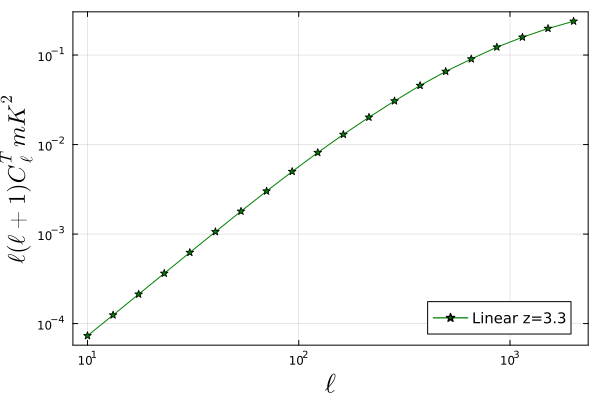

In [127]:
# Plot the results
plot(
    ell_values,
    ell_values .* (ell_values .+ 1) .* angular21cm_values,
    xscale=:log10,
    yscale=:log10,
    yticks=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1],
    xlabel= L"\ell",  # LaTeX format
    ylabel=L"\ell (\ell + 1) C^T_\ell mK^2 ",       # LaTeX format
    #title="Kappa vs Multipole Moment (l)",
    legend=true,
    label = "Linear z=$redshift",
    color= "green",
    marker=:star5,
    linestyle=:solid,
    grid=true,
    xlabelfontsize=18,  # Increase x-axis label font size
    ylabelfontsize=16
)
plot!(
    framestyle=:box,
    legend=:bottomright,
    legendfontsize=10  # Increase legend font size
)